In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os
import imageio
from datetime import timedelta
from missingpy import KNNImputer
import seaborn as sns

Ricerca dataset per Gabri Oliva - in collaborazione con Davide Andreoli

# Df claim

In [4]:
data_path= r'./Claims_data/'

In [5]:
df_claims = pd.read_csv(data_path + 'Consumer_Complaints.csv')
print(df_claims.shape)
df_claims.head(5)

(903983, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,3/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,3/17/2014,Closed with explanation,Yes,No,759217
1,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/5/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,6/8/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,6/10/2014,Closed with explanation,Yes,Yes,885638
4,9/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,9/13/2014,Closed with explanation,Yes,Yes,1027760


# Df credit score

In [6]:
df_credit = pd.read_excel(data_path + 'usa_creditscore.xlsx')
print(df_credit.shape)
df_credit.rename(index=str, columns={'State': 'state_full'}, inplace=True)
df_credit.head(5)

(50, 3)


,state_full,Credit Score,Credit Score Group
0,Illinois,BBB,Group1
1,New Jersey,A-,Group1
2,Kentucky,A+,Group1
3,West Virginia,AA-,Group2
4,Pennsylvania,AA-,Group2


In [7]:
# crea dictionary per conversione abbreviazione: full name dello stato
dict_states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [8]:
# mappa il dizionario al dataframe per ottenere nuova colonna con il nome esteso dello stato
df_claims['state_full']= df_claims['State'].map(dict_states)
# merge con il df del credito 
df_claims= df_claims.merge(df_credit, on='state_full')
# numero di lamentele per prodotto 
df_claims['Product'].value_counts()

Mortgage                                                                        238407
Debt collection                                                                 168912
Credit reporting                                                                138413
Credit card                                                                      87368
Bank account or service                                                          83579
Credit reporting, credit repair services, or other personal consumer reports     57695
Student loan                                                                     37745
Consumer Loan                                                                    31131
Credit card or prepaid card                                                      11425
Checking or savings account                                                       9244
Payday loan                                                                       5482
Money transfers                            

In [9]:
# numero di lamentele per prodotto per Credit score
df_claims.groupby(['Credit Score', 'Product'])['Product'].count()

Credit Score  Product                                                                     
A+            Bank account or service                                                           538
              Checking or savings account                                                        49
              Consumer Loan                                                                     270
              Credit card                                                                       581
              Credit card or prepaid card                                                        68
              Credit reporting                                                                 1085
              Credit reporting, credit repair services, or other personal consumer reports      559
              Debt collection                                                                  1546
              Money transfer, virtual currency, or money service                                 16
         

In [10]:
# date di inizio e fine per il monitoraggio dei prodotti
df_claims['Date received']= pd.to_datetime(df_claims['Date received'], format= '%m/%d/%Y')
df_claims.groupby('Product')['Date received'].agg({'min_date' : min, 'max_date' : max, 'count_tot': 'count'}).reset_index()

c:\users\ecappella\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,Product,min_date,max_date,count_tot
0,Bank account or service,2012-03-01,2017-04-22,83579
1,Checking or savings account,2017-04-21,2017-11-14,9244
2,Consumer Loan,2012-03-01,2017-04-21,31131
3,Credit card,2011-12-01,2017-04-22,87368
4,Credit card or prepaid card,2017-04-24,2017-11-14,11425
5,Credit reporting,2012-10-22,2017-04-22,138413
6,"Credit reporting, credit repair services, or o...",2017-04-24,2017-11-15,57695
7,Debt collection,2013-07-10,2017-11-15,168912
8,"Money transfer, virtual currency, or money ser...",2017-04-24,2017-11-13,1923
9,Money transfers,2013-04-04,2017-04-21,5087


# Crea nuovo Dataset

In [11]:
# seleziona solamente i prodotti di interesse (elimina anche debt collection)
df_claims2= df_claims[(df_claims['Product']== 'Credit card or prepaid card') | (df_claims['Product']== 'Checking or savings account')|
           (df_claims['Product']== 'Mortgage') | (df_claims['Product']== 'Credit reporting')|
         (df_claims['Product']== 'Credit card')|  (df_claims['Product']== 'Bank account or service')]
# check delle quantità
df_claims2['Product'].value_counts()

Mortgage                       238407
Credit reporting               138413
Credit card                     87368
Bank account or service         83579
Credit card or prepaid card     11425
Checking or savings account      9244
Name: Product, dtype: int64

In [12]:
# unisci 'Checking or savings account' a 'Bank account or service'
df_claims2['Product'].replace({'Checking or savings account': 'Bank account or service'}, inplace=True)
print(df_claims2.shape)
print(df_claims2['Product'].value_counts())

(568436, 21)
Mortgage                       238407
Credit reporting               138413
Bank account or service         92823
Credit card                     87368
Credit card or prepaid card     11425
Name: Product, dtype: int64


c:\users\ecappella\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [13]:
# cambia il livello 'Credit card or prepaid card' in'Credit card', ma solo per 'General-purpose credit card or charge card'
df_claims_cc= df_claims2[(df_claims2['Product']=='Credit card or prepaid card') & (df_claims2['Sub-product']=='General-purpose credit card or charge card')]\
         .replace({'Credit card or prepaid card': 'Credit card'})
df_claims_cc['Product'].value_counts()

Credit card    8846
Name: Product, dtype: int64

In [14]:
# droppa credit card o prepaid nel df_claims2 (originale)...
df_claims2 = df_claims2[df_claims2.Product != 'Credit card or prepaid card']
# ...e ora aggiungilo con un concat dal df_claims_cc
df_claims2 = pd.concat([df_claims2, df_claims_cc], ignore_index=True)
del df_claims_cc
df_claims2.Product.value_counts()

Mortgage                   238407
Credit reporting           138413
Credit card                 96214
Bank account or service     92823
Name: Product, dtype: int64

In [15]:
# ordina per data il df_claims2
df_claims2= df_claims2.sort_values('Date received').reset_index(drop=True)
# rinomina Date received in Date 
df_claims2.rename(columns={'Date received': 'Date'}, inplace=True)
# crea colonna prodotto_livello
df_claims2['prodotto_livello']= df_claims2['Product'] + '_' + df_claims2['Credit Score Group']

In [16]:
# reshape il df 
claim_stock_reshaped= df_claims2.groupby(['Date', 'prodotto_livello'])['prodotto_livello'].count().unstack().reset_index()
# mergi con le altre colonne di interesse (indici finanziari)
claim_stock_reshaped.head()

prodotto_livello,Date,Bank account or service_Group1,Bank account or service_Group2,Bank account or service_Group3,Bank account or service_Group4,Bank account or service_Group5,Credit card_Group1,Credit card_Group2,Credit card_Group3,Credit card_Group4,...,Credit reporting_Group1,Credit reporting_Group2,Credit reporting_Group3,Credit reporting_Group4,Credit reporting_Group5,Mortgage_Group1,Mortgage_Group2,Mortgage_Group3,Mortgage_Group4,Mortgage_Group5
0,2011-12-01,NaN,NaN,NaN,NaN,NaN,9.0,16.0,9.0,20.0,...,NaN,NaN,NaN,NaN,NaN,2.0,6.0,4.0,10.0,11.0
1,2011-12-02,NaN,NaN,NaN,NaN,NaN,9.0,20.0,14.0,29.0,...,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,6.0,7.0
2,2011-12-03,NaN,NaN,NaN,NaN,NaN,3.0,5.0,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,2.0
3,2011-12-04,NaN,NaN,NaN,NaN,NaN,1.0,4.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,4.0
4,2011-12-05,NaN,NaN,NaN,NaN,NaN,9.0,30.0,5.0,40.0,...,NaN,NaN,NaN,NaN,NaN,1.0,8.0,1.0,5.0,8.0


In [17]:
#cut to 22 ottobre 2012 
claim_stock_reshaped= claim_stock_reshaped[claim_stock_reshaped.Date> '2012-10-21'].reset_index(drop=True)
# del name of index
del claim_stock_reshaped.columns.name
claim_stock_reshaped.shape

(1850, 21)

# KNN imputation using missingpy
* fancyimpute non funziona
* IterativeImputer di scikitLearn pure non mi funziona

In [18]:
print(claim_stock_reshaped.shape)
claim_stock_reshaped.head()

(1850, 21)


,Date,Bank account or service_Group1,Bank account or service_Group2,Bank account or service_Group3,Bank account or service_Group4,Bank account or service_Group5,Credit card_Group1,Credit card_Group2,Credit card_Group3,Credit card_Group4,...,Credit reporting_Group1,Credit reporting_Group2,Credit reporting_Group3,Credit reporting_Group4,Credit reporting_Group5,Mortgage_Group1,Mortgage_Group2,Mortgage_Group3,Mortgage_Group4,Mortgage_Group5
0,2012-10-22,6.0,14.0,11.0,10.0,19.0,6.0,6.0,5.0,17.0,...,1.0,6.0,2.0,5.0,5.0,20.0,38.0,17.0,33.0,47.0
1,2012-10-23,2.0,19.0,3.0,13.0,23.0,4.0,10.0,10.0,9.0,...,2.0,17.0,1.0,9.0,22.0,11.0,48.0,11.0,19.0,39.0
2,2012-10-24,6.0,11.0,6.0,11.0,16.0,7.0,14.0,3.0,13.0,...,5.0,10.0,7.0,8.0,24.0,14.0,45.0,13.0,24.0,51.0
3,2012-10-25,4.0,10.0,7.0,10.0,15.0,7.0,9.0,9.0,14.0,...,5.0,7.0,5.0,9.0,22.0,5.0,35.0,10.0,15.0,45.0
4,2012-10-26,6.0,15.0,3.0,12.0,20.0,2.0,15.0,1.0,11.0,...,1.0,5.0,4.0,11.0,13.0,13.0,33.0,12.0,24.0,42.0


In [19]:
# first create a copy of the dataframe so that you can try different imputation methods
second_claim_stock= claim_stock_reshaped.copy()
# check number of missing values
print(claim_stock_reshaped.isna().sum())
# fit imputer on numerical columns transformed to array
imputer = KNNImputer()
X_imputed = pd.DataFrame(imputer.fit_transform(claim_stock_reshaped.select_dtypes(include=[np.float])))
print(X_imputed.shape)

Date                                0
Bank account or service_Group1    197
Bank account or service_Group2     70
Bank account or service_Group3    212
Bank account or service_Group4     76
Bank account or service_Group5     35
Credit card_Group1                150
Credit card_Group2                 19
Credit card_Group3                 96
Credit card_Group4                 22
Credit card_Group5                 10
Credit reporting_Group1           350
Credit reporting_Group2           223
Credit reporting_Group3           270
Credit reporting_Group4           226
Credit reporting_Group5           210
Mortgage_Group1                    57
Mortgage_Group2                     8
Mortgage_Group3                    36
Mortgage_Group4                     9
Mortgage_Group5                     7
dtype: int64
(1850, 20)

c:\users\ecappella\appdata\local\programs\python\python37\lib\site-packages\missingpy\knnimpute.py:224: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  .format(self.row_max_missing * 100))
c:\users\ecappella\appdata\local\programs\python\python37\lib\site-packages\missingpy\knnimpute.py:282: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  .format(self.row_max_missing * 100))
c:\users\ecappella\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
c:\users\ecappella\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed

In [20]:
# store name of columns
X_imputed.columns = claim_stock_reshaped.columns[1:]
claim_stock_reshaped= pd.concat([claim_stock_reshaped.iloc[:, 0], X_imputed], axis=1)
print(claim_stock_reshaped.shape)
print(claim_stock_reshaped.isna().sum())
claim_stock_reshaped.head()

(1850, 21)
Date                              0
Bank account or service_Group1    0
Bank account or service_Group2    0
Bank account or service_Group3    0
Bank account or service_Group4    0
Bank account or service_Group5    0
Credit card_Group1                0
Credit card_Group2                0
Credit card_Group3                0
Credit card_Group4                0
Credit card_Group5                0
Credit reporting_Group1           0
Credit reporting_Group2           0
Credit reporting_Group3           0
Credit reporting_Group4           0
Credit reporting_Group5           0
Mortgage_Group1                   0
Mortgage_Group2                   0
Mortgage_Group3                   0
Mortgage_Group4                   0
Mortgage_Group5                   0
dtype: int64


,Date,Bank account or service_Group1,Bank account or service_Group2,Bank account or service_Group3,Bank account or service_Group4,Bank account or service_Group5,Credit card_Group1,Credit card_Group2,Credit card_Group3,Credit card_Group4,...,Credit reporting_Group1,Credit reporting_Group2,Credit reporting_Group3,Credit reporting_Group4,Credit reporting_Group5,Mortgage_Group1,Mortgage_Group2,Mortgage_Group3,Mortgage_Group4,Mortgage_Group5
0,2012-10-22,6.0,14.0,11.0,10.0,19.0,6.0,6.0,5.0,17.0,...,1.0,6.0,2.0,5.0,5.0,20.0,38.0,17.0,33.0,47.0
1,2012-10-23,2.0,19.0,3.0,13.0,23.0,4.0,10.0,10.0,9.0,...,2.0,17.0,1.0,9.0,22.0,11.0,48.0,11.0,19.0,39.0
2,2012-10-24,6.0,11.0,6.0,11.0,16.0,7.0,14.0,3.0,13.0,...,5.0,10.0,7.0,8.0,24.0,14.0,45.0,13.0,24.0,51.0
3,2012-10-25,4.0,10.0,7.0,10.0,15.0,7.0,9.0,9.0,14.0,...,5.0,7.0,5.0,9.0,22.0,5.0,35.0,10.0,15.0,45.0
4,2012-10-26,6.0,15.0,3.0,12.0,20.0,2.0,15.0,1.0,11.0,...,1.0,5.0,4.0,11.0,13.0,13.0,33.0,12.0,24.0,42.0


In [21]:
# check max date claim dataset
claim_stock_reshaped.Date.max()

Timestamp('2017-11-15 00:00:00')

# Aggiungi dati stock exchange

In [22]:
stock_df = pd.read_excel(data_path + 'Financial Indexes.xlsx')
print(stock_df.info())
print(stock_df.Date.max())
print(stock_df.Date.min())
stock_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1897 entries, 0 to 1896
Data columns (total 5 columns):
Date                       1897 non-null datetime64[ns]
NASDAQ (IXIC) Closing      1897 non-null float64
NYSE (NYA) Closing         1897 non-null float64
Dow Jones (DJI) Closing    1897 non-null float64
S&P 500 (GSPC) Closing     1897 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 74.2 KB
None
2017-12-31 00:00:00
2012-10-22 00:00:00


,Date,NASDAQ (IXIC) Closing,NYSE (NYA) Closing,Dow Jones (DJI) Closing,S&P 500 (GSPC) Closing
0,2012-10-22,3016.959961,8329.179688,13345.889648,1433.819946
1,2012-10-23,2990.459961,8195.309570,13102.530273,1413.109985
2,2012-10-24,2981.699951,8179.259766,13077.339844,1408.750000
3,2012-10-25,2986.120117,8211.910156,13103.679688,1412.969971
4,2012-10-26,2987.949951,8190.200195,13107.209961,1411.939941


In [23]:
# mergi con claim_stock_reshape
claim_stock_reshaped= claim_stock_reshaped.merge(stock_df, on='Date', how='right')
claim_stock_reshaped.tail()

,Date,Bank account or service_Group1,Bank account or service_Group2,Bank account or service_Group3,Bank account or service_Group4,Bank account or service_Group5,Credit card_Group1,Credit card_Group2,Credit card_Group3,Credit card_Group4,...,Credit reporting_Group5,Mortgage_Group1,Mortgage_Group2,Mortgage_Group3,Mortgage_Group4,Mortgage_Group5,NASDAQ (IXIC) Closing,NYSE (NYA) Closing,Dow Jones (DJI) Closing,S&P 500 (GSPC) Closing
1892,2017-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6939.339844,12821.990234,24774.300781,2682.620117
1893,2017-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6950.160156,12853.089844,24837.509766,2687.540039
1894,2017-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6903.390137,12808.839844,24719.220703,2673.610107
1895,2017-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6903.390137,12808.839844,24719.220703,2673.610107
1896,2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6903.390137,12808.839844,24719.220703,2673.610107


In [24]:
# check new max date of claim_stock_reshaped
claim_stock_reshaped.Date.max()
# ordina per data 
claim_stock_reshaped= claim_stock_reshaped.sort_values('Date')
claim_stock_reshaped.to_excel(data_path + "claim_stock.xlsx", index=False)

# Df eventi meteo

In [25]:
df_weather = pd.read_csv(data_path + 'Storm Events.csv', low_memory=False, usecols =['STATE', 'BEGIN_DATE_TIME', 
                                                                                     'Injuries and Deaths', 
                                                                                     'Event Damage', 
                                                                                     'EVENT_ID', 'Impactful', 'Duration'])
print(df_weather.shape)
df_weather.head()  

(354768, 7)


,EVENT_ID,STATE,BEGIN_DATE_TIME,Injuries and Deaths,Event Damage,Impactful,Duration
0,428049,NEBRASKA,01/01/13,0,0,0,30
1,428026,NEBRASKA,01/01/13,0,0,0,30
2,428050,NEBRASKA,01/01/13,0,0,0,30
3,428051,NEBRASKA,01/01/13,0,0,0,30
4,428052,NEBRASKA,01/01/13,0,0,0,30


### Aggiungi Righe per durata

In [26]:
print('Before: ', str(df_weather['EVENT_ID'][df_weather.EVENT_ID==428049].count()))
# add 30 rows
df_weather = pd.DataFrame(np.repeat(df_weather.values, df_weather['Duration'].replace(0,1).tolist(), axis=0), columns=df_weather.columns)
# Date formatting
df_weather['BEGIN_DATE_TIME']= pd.to_datetime(df_weather['BEGIN_DATE_TIME'], format= '%d/%m/%y')
print('After: ', str(df_weather['EVENT_ID'][df_weather.EVENT_ID==428049].count()))

Before:  1
After:  30


### groupby + Apply + lambda

In [27]:
playing_ground= df_weather[:5000]
p = playing_ground.groupby(['EVENT_ID']).apply(lambda x: x.Duration.count()/x.Duration.max())\
                                        .reset_index().rename(columns= {0:'Duration_R'})
playing_ground = playing_ground.merge(pd.DataFrame(p), on='EVENT_ID')
playing_ground.tail()

,EVENT_ID,STATE,BEGIN_DATE_TIME,Injuries and Deaths,Event Damage,Impactful,Duration,Duration_R
4995,422195,GEORGIA,2013-01-01,0,0,0,30,0.2
4996,422195,GEORGIA,2013-01-01,0,0,0,30,0.2
4997,422195,GEORGIA,2013-01-01,0,0,0,30,0.2
4998,422195,GEORGIA,2013-01-01,0,0,0,30,0.2
4999,422195,GEORGIA,2013-01-01,0,0,0,30,0.2


### Groupby + Apply + def

In [28]:
def compute_dur(x):
    return(x.Duration.count()/x.Duration.max())

p = playing_ground.groupby(['EVENT_ID']).apply(compute_dur)
p = p.reset_index().rename(columns= {0:'Duration_R'})
playing_ground = playing_ground.merge(pd.DataFrame(p), on='EVENT_ID')
playing_ground.tail()

,EVENT_ID,STATE,BEGIN_DATE_TIME,Injuries and Deaths,Event Damage,Impactful,Duration,Duration_R_x,Duration_R_y
4995,422195,GEORGIA,2013-01-01,0,0,0,30,0.2,0.2
4996,422195,GEORGIA,2013-01-01,0,0,0,30,0.2,0.2
4997,422195,GEORGIA,2013-01-01,0,0,0,30,0.2,0.2
4998,422195,GEORGIA,2013-01-01,0,0,0,30,0.2,0.2
4999,422195,GEORGIA,2013-01-01,0,0,0,30,0.2,0.2


### Apply row by row

In [29]:
# Add $ symbol to numbers in event damage 
def add_money_symbol(x):
    x= str(x)   
    return x + '$'
playing_ground['Event Damage'] = playing_ground['Event Damage'].apply(add_money_symbol)
# equivalent to a more straightforward playing_ground['Event Damage'].astype(str) + '$'

### Iterate over rows and chage df values

In [30]:
for i, row in playing_ground.iterrows():
    if i>0:
        if playing_ground.at[i, 'EVENT_ID'] == playing_ground.at[i-1, 'EVENT_ID']:
            playing_ground.at[i, 'BEGIN_DATE_TIME']= playing_ground.at[i-1, 'BEGIN_DATE_TIME'] + timedelta(days=1)   

### Mask - vectorized solutions

In [32]:
# segnala i giorni sfigati (venerdì 13 o 17)
df_weather.loc[:, 'day_of_week'] = df_weather.loc[:, 'BEGIN_DATE_TIME'].dt.day_name()
mask = ((df_weather['BEGIN_DATE_TIME'].dt.day == 17) | (df_weather['BEGIN_DATE_TIME'].dt.day == 13)) &\
                                (df_weather['day_of_week'] == 'Friday')
df_weather.loc[mask, 'day_of_week'] = 'giorno sfigatoooooo'
df_weather['day_of_week'][df_weather['day_of_week'].str.contains('ooo')].count()

3340

In [33]:
# For events that span more than one day, this code will create new rows (one for each additional day of duration)
# the total damage (human and economic) of the event will be evenly distributed among all the days of the duration
for i in df_weather.index:
    if  df_weather.at[i, 'Duration'] > 0:
            df_weather.at[i, 'Injuries and Deaths'] = df_weather.at[i, 'Injuries and Deaths']/(df_weather.at[i, 'Duration']+1)
            df_weather.at[i, 'Event Damage'] = df_weather.at[i, 'Event Damage']/(df_weather.at[i, 'Duration']+1)
    if i > 0:        
        if df_weather.at[i, 'EVENT_ID']==df_weather.at[i-1, 'EVENT_ID']:
            df_weather.at[i, 'Injuries and Deaths'] = df_weather.at[i-1, 'Injuries and Deaths']
            df_weather.at[i, 'Event Damage'] = df_weather.at[i-1, 'Event Damage']
            df_weather.at[i, 'Duration'] = 0
            df_weather.at[i, 'Impactful'] = df_weather.at[i-1, 'Impactful'] 
            df_weather.at[i, 'BEGIN_DATE_TIME'] = df_weather.at[i-1, 'BEGIN_DATE_TIME'] + timedelta(days=1)   

In [34]:
# For events that span more than one day, this code will create new rows (one for each additional day of duration)
# the total damage (human and economic) of the event will refer only to the first day on which the event occurred

#for i in df_weather.index:
#    if i != 0:
#        if df_weather.at[i, 'EVENT_ID']==df_weather.at[i-1, 'EVENT_ID']:
#            df_weather.at[i, 'Injuries and Deaths'] = 0
#            df_weather.at[i, 'Event Damage'] = 0
#            df_weather.at[i, 'Duration'] = 0
#            df_weather.at[i, 'Impactful'] = df_weather.at[i-1, 'Impactful'] 
#            df_weather.at[i, 'BEGIN_DATE_TIME'] = df_weather.at[i-1, 'BEGIN_DATE_TIME'] + timedelta(days=1) 

In [35]:
# check last date del dataset meteo
df_weather['BEGIN_DATE_TIME'].max()

Timestamp('2017-12-31 00:00:00')

In [36]:
# creo la colonna 'state_full' su cui fare il merge con il dataset del credit score degli stati
df_weather['state_full']=df_weather['STATE'].str.lower()
df_weather['state_full']=df_weather['state_full'].str.title()
# merge con il dataset del credit score degli stati
df_weather= df_weather.merge(df_credit, on='state_full')
# converti in datetime la data con il giusto formato
df_weather['Date']= pd.to_datetime(df_weather['BEGIN_DATE_TIME'], format= '%d/%m/%y')
# create new columns of interest Event Id is a count of the claims occurence e injuries la somma degli incidenti per ogni gruppo
stock_weather= df_weather.groupby(['Date', 'Credit Score Group']).\
                    agg({'EVENT_ID' : 'count', 'Injuries and Deaths' : sum, 'Event Damage': sum, 'Impactful': sum})\
                    .unstack(level=1).reset_index()

In [37]:
# Rinomina multiindex: https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns
mi = stock_weather.columns
ind = pd.Index([e[0] + '_' + e[1] for e in mi.tolist()])
stock_weather.columns = ind

In [38]:
# rename Date
stock_weather.rename(columns={'Date_':'Date'}, inplace=True)
stock_weather.head()

,Date,EVENT_ID_Group1,EVENT_ID_Group2,EVENT_ID_Group3,EVENT_ID_Group4,EVENT_ID_Group5,Injuries and Deaths_Group1,Injuries and Deaths_Group2,Injuries and Deaths_Group3,Injuries and Deaths_Group4,...,Event Damage_Group1,Event Damage_Group2,Event Damage_Group3,Event Damage_Group4,Event Damage_Group5,Impactful_Group1,Impactful_Group2,Impactful_Group3,Impactful_Group4,Impactful_Group5
0,2012-01-01,16.0,43.0,84.0,142.0,238.0,0.0,0.0,1.0,0.0,...,52100.0,175000.0,28553.446553,265500.0,1.145051e+06,0.0,0.0,0.0,0.0,1.0
1,2012-01-02,47.0,54.0,58.0,154.0,242.0,16.0,18.0,0.0,0.0,...,55000.0,110000.0,1553.446553,215500.0,8.210509e+05,0.0,1.0,0.0,0.0,1.0
2,2012-01-03,6.0,5.0,59.0,124.0,219.0,0.0,0.0,0.0,0.0,...,4000.0,0.0,1553.446553,2500.0,9.317176e+05,0.0,0.0,0.0,0.0,1.0
3,2012-01-04,NaN,3.0,63.0,128.0,227.0,NaN,0.0,0.0,0.0,...,NaN,0.0,1553.446553,0.0,8.777176e+05,NaN,0.0,0.0,0.0,1.0
4,2012-01-05,NaN,NaN,64.0,122.0,213.0,NaN,NaN,0.0,0.0,...,NaN,NaN,1553.446553,0.0,8.110509e+05,NaN,NaN,0.0,0.0,1.0


In [39]:
# fillna with 0
stock_weather.fillna(0, inplace=True)
stock_weather.isna().sum()

Date                          0
EVENT_ID_Group1               0
EVENT_ID_Group2               0
EVENT_ID_Group3               0
EVENT_ID_Group4               0
EVENT_ID_Group5               0
Injuries and Deaths_Group1    0
Injuries and Deaths_Group2    0
Injuries and Deaths_Group3    0
Injuries and Deaths_Group4    0
Injuries and Deaths_Group5    0
Event Damage_Group1           0
Event Damage_Group2           0
Event Damage_Group3           0
Event Damage_Group4           0
Event Damage_Group5           0
Impactful_Group1              0
Impactful_Group2              0
Impactful_Group3              0
Impactful_Group4              0
Impactful_Group5              0
dtype: int64

# Final Merge

In [40]:
claim_stock_meteo = claim_stock_reshaped.merge(stock_weather, on='Date', how='left')
claim_stock_meteo.set_index('Date', inplace=True)
claim_stock_meteo.tail()

,Bank account or service_Group1,Bank account or service_Group2,Bank account or service_Group3,Bank account or service_Group4,Bank account or service_Group5,Credit card_Group1,Credit card_Group2,Credit card_Group3,Credit card_Group4,Credit card_Group5,...,Event Damage_Group1,Event Damage_Group2,Event Damage_Group3,Event Damage_Group4,Event Damage_Group5,Impactful_Group1,Impactful_Group2,Impactful_Group3,Impactful_Group4,Impactful_Group5
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.000000,0.0,2333.333333,0.0,0.0,0.0,0.0,0.0
2017-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6666.666667,3000.0,0.000000,0.0,0.0,0.0,0.0,0.0
2017-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,300000.0,11666.666667,275500.0,0.000000,0.0,0.0,0.0,0.0,0.0
2017-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70000.0,0.000000,216500.0,10000.000000,0.0,0.0,0.0,0.0,0.0
2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.000000,0.0,235000.000000,0.0,0.0,0.0,0.0,0.0


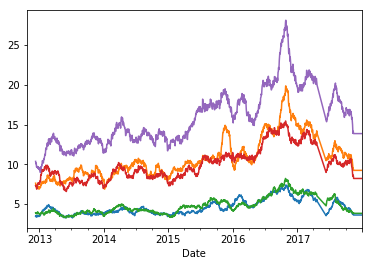

In [41]:
# plot rolling mean + interpolate missing data
claim_stock_meteo['Bank account or service_Group1'].rolling(window=50).mean().interpolate('linear').plot()
claim_stock_meteo['Bank account or service_Group2'].rolling(window=50).mean().interpolate('linear').plot()
claim_stock_meteo['Bank account or service_Group3'].rolling(window=50).mean().interpolate('linear').plot()
claim_stock_meteo['Bank account or service_Group4'].rolling(window=50).mean().interpolate('linear').plot()
claim_stock_meteo['Bank account or service_Group5'].rolling(window=50).mean().interpolate('linear').plot()

In [40]:
claim_stock_meteo.to_excel(data_path + "claim_stock_meteo.xlsx", index=False)